In [37]:
import torch
import torch.nn as nn
import data.datasets as dataSource
import torch.utils.data as tdata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import magnetoptimiser
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")


import cvxpy as cp

In [12]:
dataset_train, dataset_val = dataSource.Dipole_H_train, dataSource.Dipole_H_val
#print(dataset_train.input_columns)
batch_size = 16
important_cols = ["B_design","aper_x", "aper_y", "fieldTolerance", "maxCurrentDensity" , "rho0", "w_leg_factor", "usedPowerInPercent"]
important_cols_order = sorted(important_cols,key=lambda c: dataset_train.input_columns.index(c))

print(important_cols)
print(important_cols_order)

input_mask = [True if col in important_cols else False for col in dataset_train.input_columns]
train_loader, val_loader = tdata.DataLoader(dataset_train,batch_size), tdata.DataLoader(dataset_val,batch_size)

target_index_dict = {col:i for i,col in enumerate(dataset_train.target_columns)}
target_cols = ["B0","gfr_x_1e-2","gfr_y_1e-2"]
output_mask = [True if col in target_cols else False for col in dataset_train.target_columns]

['B_design', 'aper_x', 'aper_y', 'fieldTolerance', 'maxCurrentDensity', 'rho0', 'w_leg_factor', 'usedPowerInPercent']
['fieldTolerance', 'maxCurrentDensity', 'rho0', 'usedPowerInPercent', 'w_leg_factor', 'B_design', 'aper_x', 'aper_y']


In [13]:
network_wrapper = magnetoptimiser.wrappers.Wrapper_Dipole_Hshape_RegNet_v002

In [21]:
errors = {error_type: {"B0":[],"gfr_x":[],"gfr_y":[]} for error_type in ["abs","rel","mse"]}
scatter_plot_points = {"B0":[],"gfr_x":[],"gfr_y":[]}
single_sample_loader =  tdata.DataLoader(dataset_val, 1)

for x,y in single_sample_loader:
    selected_x = x[:,input_mask].double().to(device)
    #print(selected_x)
    selected_y = y[:,output_mask].double().to(device)
    pred = network_wrapper.predict(selected_x)[:,output_mask]
    scatter_plot_points["B0"].append((pred[:,0],selected_y[:,0]))
    scatter_plot_points["gfr_x"].append((pred[:,1],selected_y[:,1]))
    scatter_plot_points["gfr_y"].append((pred[:,2],selected_y[:,2]))

    #print(pred,selected_y)
    abs_errors = pred - selected_y.numpy()
    errors["abs"]["B0"].append(abs_errors[:,0])
    errors["abs"]["gfr_x"].append(abs_errors[:,1])
    errors["abs"]["gfr_y"].append(abs_errors[:,2])

    rel_errors = 1 - (pred/selected_y.numpy())
    errors["rel"]["B0"].append(rel_errors[:,0])
    errors["rel"]["gfr_x"].append(rel_errors[:,1])
    errors["rel"]["gfr_y"].append(rel_errors[:,2])

    mse_error = (pred - selected_y.numpy())**2
    errors["mse"]["B0"].append(mse_error[:,0])
    errors["mse"]["gfr_x"].append(mse_error[:,1])
    errors["mse"]["gfr_y"].append(mse_error[:,2])
    
mean_errors = {error_type: {quantity: sum(map(lambda v: abs(v),l))/len(l) for quantity, l in dictt.items()} for error_type, dictt in errors.items()}
max_errors = {error_type: {quantity: max(map(lambda v: abs(v),l)) for quantity, l in dictt.items()} for error_type, dictt in errors.items()}
print(mean_errors)
print(max_errors)

{'abs': {'B0': array([0.00430999]), 'gfr_x': array([0.00250086]), 'gfr_y': array([0.0004026])}, 'rel': {'B0': array([0.01795317]), 'gfr_x': array([0.01173353]), 'gfr_y': array([0.01063535])}, 'mse': {'B0': array([3.16308074e-05]), 'gfr_x': array([1.30223782e-05]), 'gfr_y': array([2.54520974e-07])}}
{'abs': {'B0': array([0.03350081]), 'gfr_x': array([0.0373228]), 'gfr_y': array([0.00282468])}, 'rel': {'B0': array([0.83611439]), 'gfr_x': array([0.17728776]), 'gfr_y': array([0.08162017])}, 'mse': {'B0': array([0.0011223]), 'gfr_x': array([0.00139299]), 'gfr_y': array([7.97881351e-06])}}


In [33]:
cols = {"B0":{"pred":[],"target":[]},"gfr_x":{"pred":[],"target":[]},"gfr_y":{"pred":[],"target":[]}}
single_sample_loader =  tdata.DataLoader(dataset_val, 1)

for x,y in single_sample_loader:
    
    selected_x = x[:,input_mask].double().to(device)
    target = y[:,output_mask].double().to(device)
    pred = network_wrapper.predict(selected_x)[:,output_mask]

    cols["B0"]["pred"].append(pred[:,0][0])
    cols["B0"]["target"].append(target[:,0].numpy()[0])

    cols["gfr_x"]["pred"].append(pred[:,1][0])
    cols["gfr_x"]["target"].append(target[:,1].numpy()[0])

    cols["gfr_y"]["pred"].append(pred[:,2][0])
    cols["gfr_y"]["target"].append(target[:,2].numpy()[0])


In [34]:
col_names = [quantity + "_" + col_name for quantity, measures in cols.items() for col_name,_ in measures.items()]
df = pd.DataFrame([row for row in zip(*[col for quantity, measures in cols.items() for _,col in measures.items()])],columns=col_names)
df = df \
.assign(B0_diff=df.apply(lambda r: r["B0_pred"] - r["B0_target"] ,axis=1))\
.assign(gfr_x_diff=df.apply(lambda r: r["gfr_x_pred"] - r["gfr_x_target"] ,axis=1))\
.assign(gfr_y_diff=df.apply(lambda r: r["gfr_y_pred"] - r["gfr_y_target"] ,axis=1))\
.assign(B0_diff_abs=df.apply(lambda r: abs(r["B0_pred"] - r["B0_target"]) ,axis=1))\
.assign(gfr_x_diff_abs=df.apply(lambda r: abs(r["gfr_x_pred"] - r["gfr_x_target"]) ,axis=1))\
.assign(gfr_y_diff_abs=df.apply(lambda r: abs(r["gfr_y_pred"] - r["gfr_y_target"]) ,axis=1))\
.assign(B0_diff_rel=df.apply(lambda r: abs(1 -r["B0_pred"]/r["B0_target"]) ,axis=1))\
.assign(gfr_x_diff_rel=df.apply(lambda r: abs(1 - r["gfr_x_pred"]/r["gfr_x_target"]) ,axis=1))\
.assign(gfr_y_diff_rel=df.apply(lambda r: abs(1 - r["gfr_y_pred"]/r["gfr_y_target"]) ,axis=1))

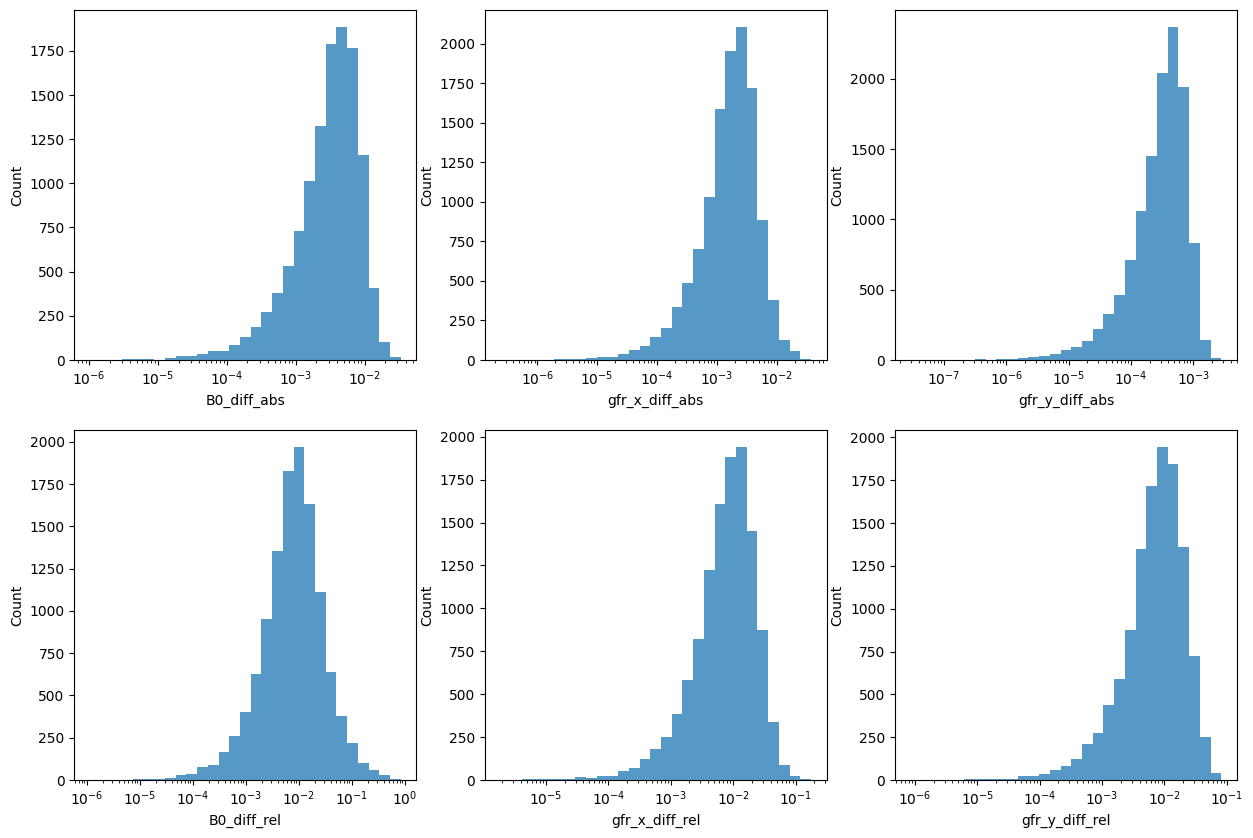

In [36]:

fig, axes = plt.subplots(2,3,figsize=(15,10))

for x,y,colname in [(0,0,"B0_diff_abs"),(0,1,"gfr_x_diff_abs"),(0,2,"gfr_y_diff_abs"),(1,0,"B0_diff_rel"),(1,1,"gfr_x_diff_rel"),(1,2,"gfr_y_diff_rel")]:
    log_min = np.log10(df[colname].min())
    log_max = np.log10(df[colname].max())
    bins = np.logspace(log_min, log_max, 30) 
    sns.histplot(ax=axes[x,y],data=df,x=colname,bins=bins)
    axes[x,y].set_xscale("log")

## Input optimization

In [ ]:
A = []
b = []

def onehot(name, neg):
    out = [0] * len(important_cols_order)
    out[important_cols_order.index(name)] = -1 if neg else 1
    return out

for name in important_cols_order:
    # constraints for minima: x > a --> -x < -a
    A.append(onehot(name,True))
    b.append(-dataset_train.input_mins[name])
    
    # constraints for maxima: x < a
    if name == "usedPowerInPercent":
        A.append(onehot(name,False))
        b.append(100)
    else:
        A.append(onehot(name,False))
        b.append(dataset_train.input_maxs[name])



[-0.0001,
 0.01,
 -0.5,
 10.0,
 -0.5,
 1.0,
 -10.0081185,
 100,
 -0.8000852,
 2.4999138,
 -0.0490074,
 2.0,
 -0.03,
 0.3,
 -0.03,
 0.3]

In [46]:
A_rel = []
b_rel = []

#['fieldTolerance', 'maxCurrentDensity', 'rho0', 'usedPowerInPercent', 'w_leg_factor', 'B_design', 'aper_x', 'aper_y']

# aper_x > aper_y --> aper_y - aper_x < 0
A_rel.append([0, 0, 0, 0, 0, 0, -1, 1])
b_rel.append(0)

# aper_x < 5 * aper_y --> aper_x - 5 * aper_y < 0
A_rel.append([0, 0, 0, 0, 0, 0, 1, -3])
b_rel.append(0)



A = A + A_rel
b = b + b_rel

In [47]:
# ratio constraints 
# compute min and max ratio for every pair of inputs and ensure the ratio is in that range with two linear constraints
# e.g. min < a/b < max -->  min * b - a < 0 and a - max * b < 0
# with slack. min * (1+e) < a/b < max * (1-e) -->  (min (1+ e)) * b - a < 0 and a - (max*(1-e)) * b < 0

A_rat = []
b_rat = []
epsilon = 1e-5

for i in range(len(important_cols_order)-1):
    for j in range(i+1,len(important_cols_order)):
        quantity_1 = important_cols_order[i]
        quantity_2 = important_cols_order[j]

        # ratio = column i/ colimn j
        ratio_df = dataset_train.dataframe.assign(ratio=dataset_train.dataframe.apply(lambda r: r[quantity_1] / r[quantity_2], axis=1))

        minimum = ratio_df["ratio"].min() 
        maximum = ratio_df["ratio"].max()

        minimum *= 1+epsilon
        maximum *= 1-epsilon

        # min * j - i < 0
        min_row = [0]*len(important_cols)
        min_row[i] = -1
        min_row[j] = minimum
        A_rat.append(min_row)
        b_rat.append(0)

        #i - max * k < 0
        max_row = [0]*len(important_cols)
        max_row[i] = 1
        max_row[j] = -maximum
        A_rat.append(max_row)
        b_rat.append(0)

        print(quantity_1,quantity_2,minimum,maximum, "-->", min_row,"< 0 and", max_row,"< 0")


A = A + A_rat
b = b + b_rat

fieldTolerance maxCurrentDensity 1.0000100000000001e-05 0.0199998 --> [-1, 1.0000100000000001e-05, 0, 0, 0, 0, 0, 0] < 0 and [1, -0.0199998, 0, 0, 0, 0, 0, 0] < 0
fieldTolerance rho0 0.00010000100000000001 0.0199998 --> [-1, 0, 0.00010000100000000001, 0, 0, 0, 0, 0] < 0 and [1, 0, -0.0199998, 0, 0, 0, 0, 0] < 0
fieldTolerance usedPowerInPercent 8.000080000000001e-07 0.0009372486996250448 --> [-1, 0, 0, 8.000080000000001e-07, 0, 0, 0, 0] < 0 and [1, 0, 0, -0.0009372486996250448, 0, 0, 0, 0] < 0
fieldTolerance w_leg_factor 4.12525439843647e-05 0.012235506744198137 --> [-1, 0, 0, 0, 4.12525439843647e-05, 0, 0, 0] < 0 and [1, 0, 0, 0, -0.012235506744198137, 0, 0, 0] < 0
fieldTolerance B_design 5.0000500000000003e-05 0.13557761627338663 --> [-1, 0, 0, 0, 0, 5.0000500000000003e-05, 0, 0] < 0 and [1, 0, 0, 0, 0, -0.13557761627338663, 0, 0] < 0
fieldTolerance aper_x 0.00033333666666666674 0.33333000000000007 --> [-1, 0, 0, 0, 0, 0, 0.00033333666666666674, 0] < 0 and [1, 0, 0, 0, 0, 0, -0.33333

In [48]:
def project_to_polytope(x, A_mat=A, b_vec = b):
    # Define decision variable
    p = cp.Variable(len(x))
    # Define objective function
    objective = cp.Minimize(cp.sum_squares(p - x))

    # Define constraints
    constraints = [np.array(A_mat) @ p <= np.array(b_vec)]

    # Solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()


    # Optimal solution
    closest_point = p.value
    return closest_point

In [73]:
network = network_wrapper.model
scaler_input = network_wrapper.scaler_x
scaler_output = network_wrapper.scaler_y
network.to(device)

RegressionNetwork(
  (layer1): Linear(in_features=8, out_features=256, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (output_layer): Linear(in_features=256, out_features=34, bias=True)
)

In [101]:
def create_loss_function(tuple_of_interest, target, scaler_output):
    mask = torch.zeros(1,34,dtype=torch.float).to(device)
    full_target = np.zeros((1,34))
    for i in tuple_of_interest:
        mask[0, i] = 1

    full_target[0,0] = target[0]
    full_target[0,tuple_of_interest[1]] = target[1]
    full_target[0,tuple_of_interest[2]] = target[2]
    scaled_target = torch.tensor(scaler_output.transform(full_target),dtype=torch.float)

    mse = torch.nn.MSELoss()
    def instanciated_loss_function(x):
        return mse(x*mask,scaled_target*mask)
    return instanciated_loss_function


In [ ]:
'''
    - optim tuple: (B0,gfr_x, gfr_y)
    - gfr_accuracies (gfr_x_acc, gfr_y_acc) 
        To select the correct outputs of the network to optimize towards
    - initial condidions double array of size 8 in order of dataset
    - vary_input: boolean array of size 8, should input i be fixed or adjusted
    - extra boundary conditions for polytope (A,b)
'''
disable_projection = False

def optim(optim_tuple={"B0":1.5,"gfr_x":0.2,"gfr_y":0.1}, gfr_accuracies=("1e-2","1e-2"), initial_conditions=np.random.random(8), vary_input=[True] * 8, extra_boundary_conditions=([],[])):

    #target_mask = [False] * 34
    #target_mask[0] = True
    #target_mask[target_index_dict[f"gfr_x_{gfr_accuracies[0]}"]] = True
    #target_mask[target_index_dict[f"gfr_y_{gfr_accuracies[1]}"]] = True
    target = [optim_tuple["B0"],optim_tuple["gfr_x"],optim_tuple["gfr_y"]]

    vary_input_tensor = torch.tensor(vary_input)
    loss_fun = create_loss_function([0,target_index_dict[f"gfr_x_{gfr_accuracies[0]}"],target_index_dict[f"gfr_y_{gfr_accuracies[1]}"]], target, scaler_output)
    
    A_intern = A + extra_boundary_conditions[0]
    b_intern = b + extra_boundary_conditions[1]

    guess = project_to_polytope(initial_conditions,A_intern,b_intern)
    
    lr = 1e-1
    n_steps = 2000

    for step in range(n_steps):
        for name, layer in network.named_parameters():
            if layer.grad is not None:
                layer.grad.zero_()
        
        scaled_guess = scaler_input.transform(guess.reshape(1, -1))
        grad_guess = torch.tensor(scaled_guess,requires_grad=True,device=device,dtype=torch.float)
        pred = network(grad_guess)
        loss = loss_fun(pred)
        loss.backward()
        next_guess = (grad_guess - lr * grad_guess.grad) * vary_input_tensor + (grad_guess * (~vary_input_tensor))
        next_guess_unscaled = scaler_input.inverse_transform(next_guess.detach().cpu().numpy())
        if disable_projection:
            guess = next_guess_unscaled
        else:
            try:
                next_guess_projected = project_to_polytope(next_guess_unscaled[0,:] ,A_intern, b_intern)
                print("solver successful")
            except:
                next_guess_projected = next_guess_unscaled[0,:] 
                print("solver failed")
            guess = next_guess_projected
        print(loss.item())


    return project_to_polytope(scaler_input.inverse_transform(guess.reshape(1, -1))[0,:],A_intern, b_intern)


params = optim()[0,:]
print(params)

solver successful
0.2355162352323532
solver successful
0.2345767766237259
solver successful
0.2336420714855194
solver successful
0.23271596431732178
solver successful
0.23180396854877472
solver successful
0.23089593648910522
solver successful
0.22999294102191925
solver successful
0.2291000634431839
solver successful
0.22818340361118317
solver successful
0.227271169424057
solver successful
0.2263636589050293
solver successful
0.22545857727527618
solver successful
0.2245481163263321
solver successful
0.2236422896385193
solver successful
0.22274114191532135
solver successful
0.2218460738658905
solver successful
0.22098930180072784
solver successful
0.22013700008392334
solver successful
0.21928787231445312
solver successful
0.21844342350959778
solver successful
0.21760326623916626
solver successful
0.21676747500896454
solver successful
0.21593591570854187
solver successful
0.21510882675647736
solver successful
0.21428604423999786
solver successful
0.21346867084503174
solver successful
0.21

ValueError: Incompatible dimensions (16, 8) (1, 1)

#['fieldTolerance', 'maxCurrentDensity', 'rho0', 'usedPowerInPercent', 'w_leg_factor', 'B_design', 'aper_x', 'aper_y']


In [112]:
import femmcreator
import magnetdesigner
#['fieldTolerance', 'maxCurrentDensity', 'rho0', 'usedPowerInPercent', 'w_leg_factor', 'B_design', 'aper_x', 'aper_y']

magnet = magnetdesigner.designer.get_Dipole(
    name=name, 
    B_design=params[5], 
    aper_x=params[6], 
    aper_y=params[7], 
    fieldTolerance=params[0], 
    rho0=params[2], 
    w_leg_factor=params[4],
    maxCurrentDensity=params[1], 
    usedPowerInPercent=params[3], 
    shape="H")

femm = femmcreator.FEMM()
femm.Build(magnet.get_femminput)
femm.CreateFEMM('dipole_H_1.5_0.2_0.1')

Exception: This method is not suitable for superconducting magnets yet. Please set a current density smaller than than 10 A/mm^2.